In [2]:
import os
import time
import tqdm
import random
import imageio
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from IPython.display import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision.utils import make_grid, save_image
from torchsummary import summary
from PIL import Image as PI
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
!rm -rf ./genimages
!mkdir -p genimages

In [4]:
np.random.seed(11)
_ = torch.manual_seed(11)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_count = torch.cuda.device_count()
torch.backends.cudnn.benchmark = True

batch_size = 1400
latent_size = 64
image_number = 25
epochs = 100
dis_learning_rate = 0.0002
gen_learning_rate = 0.0002

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [6]:
transforms = T.Compose(
    [
     T.ToTensor(),
     T.Normalize((0.5,), (0.5,))
    ]
)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, file_path, transforms=None):
        self.df = pd.read_csv(file_path)
        
        if "label" in self.df.columns:
            self.df.drop(["label"], axis=1, inplace=True)
        
        self.df = shuffle(self.df)
        self.df.reset_index(drop=True, inplace=True)

        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index].to_numpy(dtype=np.dtype('float32')).reshape(28, 28)/255.0
        
        if self.transforms:
            image = self.transforms(image)
        else:
            image = torch.from_numpy(image)
        
        return image

train_data = ImageDataset('mnist_train.csv', transforms)
test_data = ImageDataset('mnist_test.csv', transforms)

print("Train length :",len(train_data))
print("Test length :", len(test_data))

Train length : 60000
Test length : 10000


In [8]:
dataset = ConcatDataset([train_data, test_data])
print("Total length :",len(dataset))

Total length : 70000


In [9]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4*device_count, pin_memory=True)

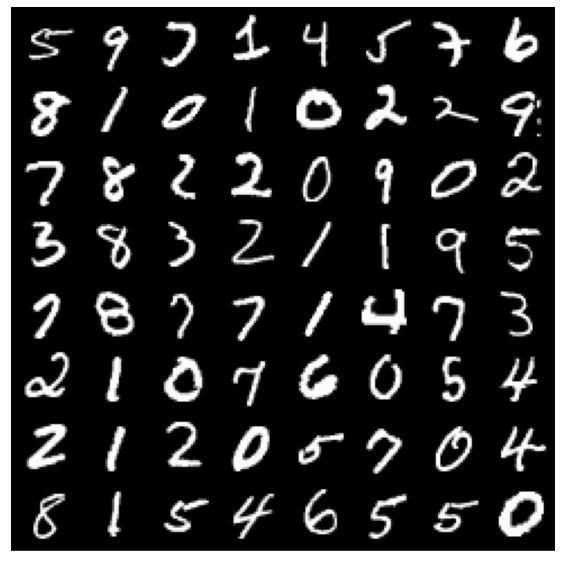

In [10]:
image = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(make_grid(image[:64], nrow=8, normalize=True).permute(1, 2, 0))
plt.show()

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1, bias=False),

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

dis = Discriminator().to(device=device)
summary(dis, input_size=(1, 28, 28), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1400, 64, 14, 14]           1,024
       BatchNorm2d-2         [1400, 64, 14, 14]             128
         LeakyReLU-3         [1400, 64, 14, 14]               0
            Conv2d-4          [1400, 128, 7, 7]         131,072
       BatchNorm2d-5          [1400, 128, 7, 7]             256
         LeakyReLU-6          [1400, 128, 7, 7]               0
            Conv2d-7          [1400, 256, 3, 3]         524,288
       BatchNorm2d-8          [1400, 256, 3, 3]             512
         LeakyReLU-9          [1400, 256, 3, 3]               0
           Conv2d-10            [1400, 1, 1, 1]           4,096
          Flatten-11                  [1400, 1]               0
          Sigmoid-12                  [1400, 1]               0
Total params: 661,376
Trainable params: 661,376
Non-trainable params: 0
-------------------------------

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 28, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(28),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(28, 1, kernel_size=4, stride=2, padding=3, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

gen = Generator().to(device=device)
summary(gen, input_size=(latent_size, 1, 1), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [1400, 256, 4, 4]         262,144
       BatchNorm2d-2          [1400, 256, 4, 4]             512
              ReLU-3          [1400, 256, 4, 4]               0
   ConvTranspose2d-4           [1400, 64, 8, 8]         262,144
       BatchNorm2d-5           [1400, 64, 8, 8]             128
              ReLU-6           [1400, 64, 8, 8]               0
   ConvTranspose2d-7         [1400, 28, 16, 16]          28,672
       BatchNorm2d-8         [1400, 28, 16, 16]              56
              ReLU-9         [1400, 28, 16, 16]               0
  ConvTranspose2d-10          [1400, 1, 28, 28]             448
             Tanh-11          [1400, 1, 28, 28]               0
Total params: 554,104
Trainable params: 554,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/

In [13]:
image_files = []
latent_vec = torch.randn(image_number, latent_size, 1, 1, device=device)
latent_vec.shape

torch.Size([25, 64, 1, 1])

In [15]:
def save_outputs(index):
    fake = gen(latent_vec)
    file_path = f'./genimages/gen-image-{index}.png'
    save_image(fake, file_path, nrow=5, normalize=True)
    image_files.append(imageio.imread(file_path))

save_outputs(0)

In [16]:
def train_discriminator(batch_size, real_images, dis_opt, loss):
    dis_opt.zero_grad()

    # ones and zeros
    ones = torch.ones(batch_size, 1, device=device)
    zeros = torch.zeros(batch_size, 1, device=device)

    # get fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = gen(latent)

    # get the prdictions
    real_preds = dis(real_images)
    fake_preds = dis(fake_images)

    # get the loss
    real_loss = loss(real_preds, ones)
    fake_loss = loss(fake_preds, zeros)

    dis_loss = (real_loss + fake_loss)/2

    ret_loss = dis_loss.item()

    # adjust the weights
    dis_loss.backward()
    dis_opt.step()

    return ret_loss

def train_generator(batch_size, gen_opt, loss):
    # train generator
    gen_opt.zero_grad()

    # ones and zeros
    ones = torch.ones(batch_size, 1, device=device)

    # get generated images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = gen(latent)

    # get the predictions
    fake_preds = dis(fake_images)

    # get the loss
    gen_loss = loss(fake_preds, ones)

    ret_loss = gen_loss.item()

    # adjust the weights
    gen_loss.backward()
    gen_opt.step()

    return ret_loss

In [17]:
def train(epochs=epochs):
    torch.cuda.empty_cache()
    
    loss = nn.BCELoss()
    loss_gen = []
    loss_dis = []

    dis_opt = optim.Adam(dis.parameters(), lr=dis_learning_rate)
    gen_opt = optim.Adam(gen.parameters(), lr=gen_learning_rate)
    
    train_start = time.time()

    for e in range(1, epochs+1):
        for real_images in tqdm.notebook.tqdm(data_loader, leave=False):
            real_images = real_images.to(device)

            dis_loss = train_discriminator(batch_size, real_images, dis_opt, loss)
            gen_loss = train_generator(batch_size, gen_opt, loss)

        end = time.time()
        
        loss_dis.append(dis_loss)
        loss_gen.append(gen_loss)
        
        print(f"Epoch[{e}/{epochs}]\t:: Discriminator Loss = {loss_dis[-1]:.4f}, Generator Loss = {loss_gen[-1]:.4f}, Total Time : {int(end - train_start)}s")

        save_outputs(e)
    
    train_end = time.time()
    
    print(f"\nTotal Time\t:: {int(train_end-train_start)} sec")
    print(f"End Training\t:: Discriminator Loss = {loss_dis[-1]:.4f}, Generator Loss = {loss_gen[-1]:.4f}")
    
    return loss_dis, loss_gen

In [18]:
losses = train()

Epoch[1/100]	:: Discriminator Loss = 0.0059, Generator Loss = 6.2448, Total Time : 36s


Epoch[2/100]	:: Discriminator Loss = 0.0021, Generator Loss = 6.8305, Total Time : 70s


Epoch[3/100]	:: Discriminator Loss = 0.0053, Generator Loss = 8.2318, Total Time : 104s


Epoch[4/100]	:: Discriminator Loss = 0.0089, Generator Loss = 7.6092, Total Time : 139s


Epoch[5/100]	:: Discriminator Loss = 0.0049, Generator Loss = 7.6462, Total Time : 173s


Epoch[6/100]	:: Discriminator Loss = 0.0019, Generator Loss = 7.7787, Total Time : 207s


Epoch[7/100]	:: Discriminator Loss = 0.0028, Generator Loss = 7.5048, Total Time : 241s


Epoch[8/100]	:: Discriminator Loss = 0.0018, Generator Loss = 8.2510, Total Time : 274s


Epoch[9/100]	:: Discriminator Loss = 0.0020, Generator Loss = 6.9472, Total Time : 308s


Epoch[10/100]	:: Discriminator Loss = 0.0258, Generator Loss = 3.8824, Total Time : 342s


Epoch[11/100]	:: Discriminator Loss = 0.0323, Generator Loss = 5.2019, Total Time : 376s


Epoch[12/100]	:: Discriminator Loss = 0.0175, Generator Loss = 5.6460, Total Time : 410s


Epoch[13/100]	:: Discriminator Loss = 0.0290, Generator Loss = 5.4469, Total Time : 445s


Epoch[14/100]	:: Discriminator Loss = 0.0180, Generator Loss = 5.6913, Total Time : 478s


Epoch[15/100]	:: Discriminator Loss = 0.0161, Generator Loss = 5.8142, Total Time : 512s


Epoch[16/100]	:: Discriminator Loss = 0.0283, Generator Loss = 5.8627, Total Time : 547s


Epoch[17/100]	:: Discriminator Loss = 0.0173, Generator Loss = 5.9795, Total Time : 581s


Epoch[18/100]	:: Discriminator Loss = 0.0103, Generator Loss = 6.2105, Total Time : 615s


Epoch[19/100]	:: Discriminator Loss = 0.0209, Generator Loss = 5.4508, Total Time : 649s


Epoch[20/100]	:: Discriminator Loss = 0.0236, Generator Loss = 5.9529, Total Time : 683s


Epoch[21/100]	:: Discriminator Loss = 0.0204, Generator Loss = 6.4806, Total Time : 717s


Epoch[22/100]	:: Discriminator Loss = 0.0185, Generator Loss = 6.9332, Total Time : 751s


Epoch[23/100]	:: Discriminator Loss = 0.0499, Generator Loss = 7.0955, Total Time : 785s


Epoch[24/100]	:: Discriminator Loss = 0.4669, Generator Loss = 1.8447, Total Time : 819s


Epoch[25/100]	:: Discriminator Loss = 0.0745, Generator Loss = 3.8779, Total Time : 853s


Epoch[26/100]	:: Discriminator Loss = 0.0734, Generator Loss = 4.2525, Total Time : 887s


Epoch[27/100]	:: Discriminator Loss = 0.0365, Generator Loss = 4.7793, Total Time : 921s


Epoch[28/100]	:: Discriminator Loss = 0.0416, Generator Loss = 5.1470, Total Time : 955s


Epoch[29/100]	:: Discriminator Loss = 0.0432, Generator Loss = 5.2604, Total Time : 989s


Epoch[30/100]	:: Discriminator Loss = 0.0301, Generator Loss = 5.1724, Total Time : 1023s


Epoch[31/100]	:: Discriminator Loss = 0.0726, Generator Loss = 4.2073, Total Time : 1057s


Epoch[32/100]	:: Discriminator Loss = 0.0665, Generator Loss = 4.8634, Total Time : 1091s


Epoch[33/100]	:: Discriminator Loss = 0.0557, Generator Loss = 6.0879, Total Time : 1125s


Epoch[34/100]	:: Discriminator Loss = 0.0347, Generator Loss = 4.7319, Total Time : 1159s


Epoch[35/100]	:: Discriminator Loss = 0.0632, Generator Loss = 4.9917, Total Time : 1193s


Epoch[36/100]	:: Discriminator Loss = 0.1595, Generator Loss = 4.5041, Total Time : 1227s


Epoch[37/100]	:: Discriminator Loss = 0.0720, Generator Loss = 4.6888, Total Time : 1261s


Epoch[38/100]	:: Discriminator Loss = 0.0635, Generator Loss = 5.1893, Total Time : 1295s


Epoch[39/100]	:: Discriminator Loss = 0.0416, Generator Loss = 5.2475, Total Time : 1329s


Epoch[40/100]	:: Discriminator Loss = 0.0374, Generator Loss = 5.1100, Total Time : 1363s


Epoch[41/100]	:: Discriminator Loss = 0.0655, Generator Loss = 4.1238, Total Time : 1397s


Epoch[42/100]	:: Discriminator Loss = 0.0425, Generator Loss = 5.1683, Total Time : 1431s


Epoch[43/100]	:: Discriminator Loss = 0.1161, Generator Loss = 3.6526, Total Time : 1465s


Epoch[44/100]	:: Discriminator Loss = 0.0672, Generator Loss = 4.1863, Total Time : 1499s


Epoch[45/100]	:: Discriminator Loss = 0.0842, Generator Loss = 3.3636, Total Time : 1533s


Epoch[46/100]	:: Discriminator Loss = 0.0586, Generator Loss = 4.1230, Total Time : 1567s


Epoch[47/100]	:: Discriminator Loss = 0.0550, Generator Loss = 4.2390, Total Time : 1601s


Epoch[48/100]	:: Discriminator Loss = 0.0550, Generator Loss = 5.1336, Total Time : 1635s


Epoch[49/100]	:: Discriminator Loss = 0.0720, Generator Loss = 3.0767, Total Time : 1670s


Epoch[50/100]	:: Discriminator Loss = 0.1544, Generator Loss = 2.8319, Total Time : 1704s


Epoch[51/100]	:: Discriminator Loss = 0.0860, Generator Loss = 3.3873, Total Time : 1738s


Epoch[52/100]	:: Discriminator Loss = 0.0784, Generator Loss = 3.6433, Total Time : 1772s


Epoch[53/100]	:: Discriminator Loss = 0.0740, Generator Loss = 3.5339, Total Time : 1806s


Epoch[54/100]	:: Discriminator Loss = 0.0580, Generator Loss = 3.4440, Total Time : 1840s


Epoch[55/100]	:: Discriminator Loss = 0.0928, Generator Loss = 3.2785, Total Time : 1874s


Epoch[56/100]	:: Discriminator Loss = 0.0846, Generator Loss = 3.5015, Total Time : 1908s


Epoch[57/100]	:: Discriminator Loss = 0.0671, Generator Loss = 4.0595, Total Time : 1942s


Epoch[58/100]	:: Discriminator Loss = 0.1152, Generator Loss = 1.9098, Total Time : 1976s


Epoch[59/100]	:: Discriminator Loss = 0.0629, Generator Loss = 4.3598, Total Time : 2010s


Epoch[60/100]	:: Discriminator Loss = 0.0777, Generator Loss = 2.9128, Total Time : 2044s


Epoch[61/100]	:: Discriminator Loss = 0.0660, Generator Loss = 4.7577, Total Time : 2078s


Epoch[62/100]	:: Discriminator Loss = 0.0803, Generator Loss = 3.5588, Total Time : 2112s


Epoch[63/100]	:: Discriminator Loss = 0.0990, Generator Loss = 5.0933, Total Time : 2146s


Epoch[64/100]	:: Discriminator Loss = 0.2224, Generator Loss = 2.6893, Total Time : 2180s


Epoch[65/100]	:: Discriminator Loss = 0.0944, Generator Loss = 3.4807, Total Time : 2214s


Epoch[66/100]	:: Discriminator Loss = 0.1127, Generator Loss = 3.5301, Total Time : 2248s


Epoch[67/100]	:: Discriminator Loss = 0.0595, Generator Loss = 3.0225, Total Time : 2282s


Epoch[68/100]	:: Discriminator Loss = 0.0830, Generator Loss = 3.5947, Total Time : 2316s


Epoch[69/100]	:: Discriminator Loss = 0.0808, Generator Loss = 4.0922, Total Time : 2350s


Epoch[70/100]	:: Discriminator Loss = 0.2575, Generator Loss = 5.2943, Total Time : 2384s


Epoch[71/100]	:: Discriminator Loss = 0.0924, Generator Loss = 3.9451, Total Time : 2418s


Epoch[72/100]	:: Discriminator Loss = 0.0919, Generator Loss = 2.0806, Total Time : 2452s


Epoch[73/100]	:: Discriminator Loss = 0.0732, Generator Loss = 2.7225, Total Time : 2486s


Epoch[74/100]	:: Discriminator Loss = 0.0827, Generator Loss = 2.3980, Total Time : 2520s


Epoch[75/100]	:: Discriminator Loss = 0.0810, Generator Loss = 2.4793, Total Time : 2554s


Epoch[76/100]	:: Discriminator Loss = 0.0883, Generator Loss = 4.4220, Total Time : 2588s


Epoch[77/100]	:: Discriminator Loss = 0.0692, Generator Loss = 3.3813, Total Time : 2622s


Epoch[78/100]	:: Discriminator Loss = 0.0908, Generator Loss = 2.0841, Total Time : 2656s


Epoch[79/100]	:: Discriminator Loss = 0.0677, Generator Loss = 4.4269, Total Time : 2690s


Epoch[80/100]	:: Discriminator Loss = 0.1026, Generator Loss = 3.8628, Total Time : 2724s


Epoch[81/100]	:: Discriminator Loss = 0.0877, Generator Loss = 4.7288, Total Time : 2758s


Epoch[82/100]	:: Discriminator Loss = 0.0748, Generator Loss = 3.9583, Total Time : 2792s


Epoch[83/100]	:: Discriminator Loss = 0.0970, Generator Loss = 3.5863, Total Time : 2826s


Epoch[84/100]	:: Discriminator Loss = 0.0978, Generator Loss = 3.4254, Total Time : 2860s


Epoch[85/100]	:: Discriminator Loss = 0.1098, Generator Loss = 2.7421, Total Time : 2894s


Epoch[86/100]	:: Discriminator Loss = 0.1031, Generator Loss = 3.7361, Total Time : 2928s


Epoch[87/100]	:: Discriminator Loss = 0.1258, Generator Loss = 2.6418, Total Time : 2962s


Epoch[88/100]	:: Discriminator Loss = 0.0889, Generator Loss = 2.4348, Total Time : 2996s


Epoch[89/100]	:: Discriminator Loss = 0.0927, Generator Loss = 2.0805, Total Time : 3030s


Epoch[90/100]	:: Discriminator Loss = 0.0668, Generator Loss = 3.2177, Total Time : 3064s


Epoch[91/100]	:: Discriminator Loss = 0.0842, Generator Loss = 4.5682, Total Time : 3098s


Epoch[92/100]	:: Discriminator Loss = 0.1212, Generator Loss = 2.6289, Total Time : 3132s


Epoch[93/100]	:: Discriminator Loss = 0.0869, Generator Loss = 4.1286, Total Time : 3167s


Epoch[94/100]	:: Discriminator Loss = 0.1584, Generator Loss = 4.5956, Total Time : 3200s


Epoch[95/100]	:: Discriminator Loss = 0.0836, Generator Loss = 2.8512, Total Time : 3235s


Epoch[96/100]	:: Discriminator Loss = 0.0797, Generator Loss = 3.6046, Total Time : 3269s


Epoch[97/100]	:: Discriminator Loss = 0.0943, Generator Loss = 3.3913, Total Time : 3303s


Epoch[98/100]	:: Discriminator Loss = 0.0961, Generator Loss = 3.1888, Total Time : 3337s


Epoch[99/100]	:: Discriminator Loss = 0.1002, Generator Loss = 2.8976, Total Time : 3371s


Epoch[100/100]	:: Discriminator Loss = 0.0799, Generator Loss = 2.4196, Total Time : 3405s

Total Time	:: 3405 sec
End Training	:: Discriminator Loss = 0.0799, Generator Loss = 2.4196


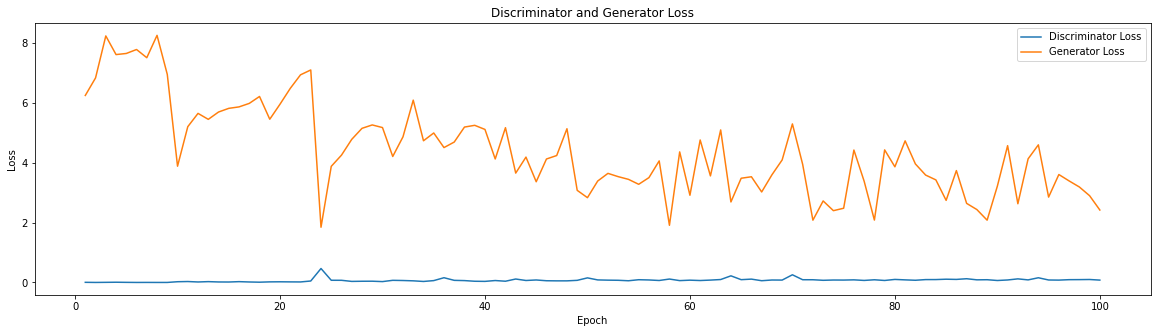

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(range(1, epochs+1), losses[0], label="Discriminator Loss")
plt.plot(range(1, epochs+1), losses[1], label="Generator Loss")
plt.title("Discriminator and Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

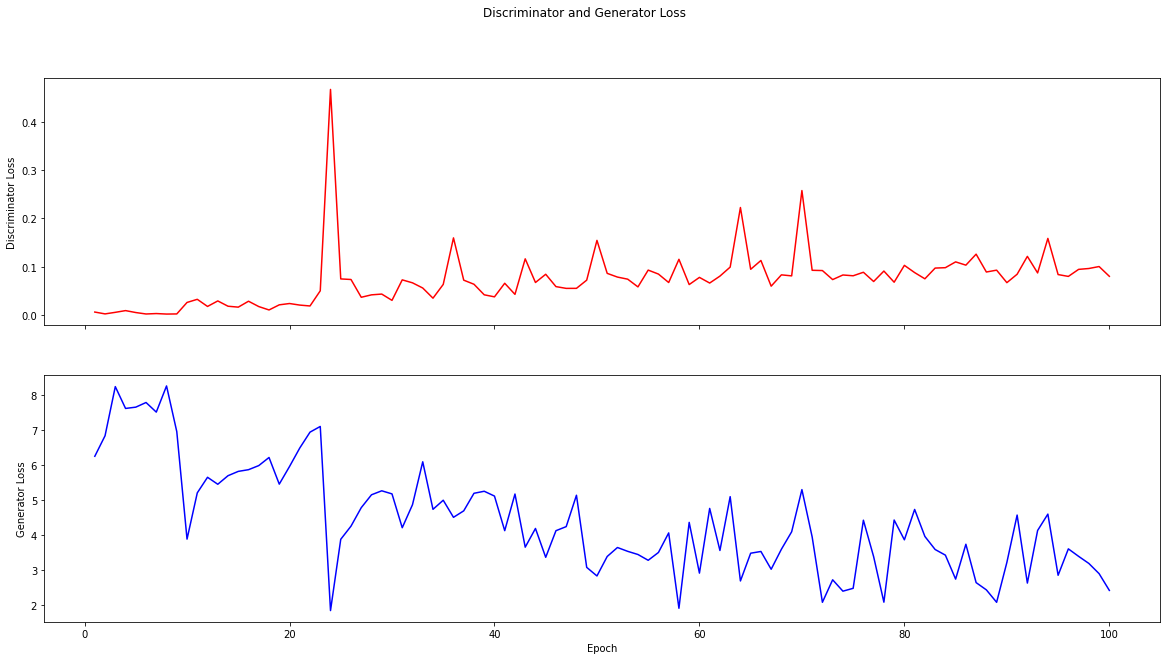

In [70]:
fig, (dis_ax, gen_ax) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

fig.suptitle("Discriminator and Generator Loss")

dis_ax.plot(range(1, epochs+1), losses[0], color='r', label="Discriminator Loss")
dis_ax.set_ylabel("Discriminator Loss")

gen_ax.plot(range(1, epochs+1), losses[1], color='b', label="Generator Loss")
gen_ax.set_ylabel("Generator Loss")
gen_ax.set_xlabel("Epoch")

plt.show()

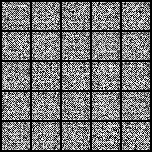

In [21]:
imageio.mimsave('./gen-images.gif', image_files, duration=0.5)
Image(open('./gen-images.gif', 'rb').read(), width=600, height=600)

In [22]:
checkpoint = {
    'discriminator' : {
        'model' : Discriminator(),
        'state_dict' : dis.state_dict()
    },
    'generator' : {
        'model' : Generator(),
        'state_dict' : gen.state_dict()
    }
}
torch.save(checkpoint, 'checkpoint.pth')

In [45]:
def load_model(file_path, device='cpu'):
    checkpoint = torch.load(file_path)
    dis = checkpoint['discriminator']['model'].to(device)
    gen = checkpoint['generator']['model'].to(device)
    dis.load_state_dict(checkpoint['discriminator']['state_dict'])
    gen.load_state_dict(checkpoint['generator']['state_dict'])

    return dis, gen
_, gen_net = load_model('checkpoint.pth', device)

In [46]:
print(gen_net)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [55]:
def show_images():
    with torch.no_grad():
        gen_net.eval()
        latent = torch.randn(image_number, latent_size, 1, 1, device=device)
        gen_images = gen_net(latent)

        plt.figure(figsize=(10, 10))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(make_grid(gen_images.cpu(), nrow=5, normalize=True).permute(1, 2, 0))
        plt.show()

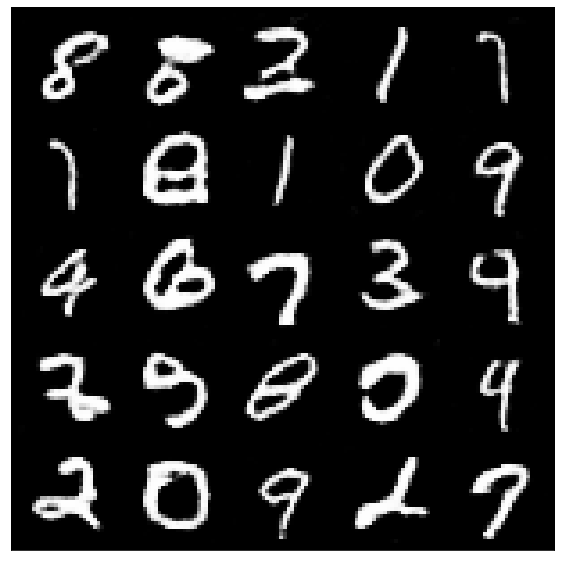

In [58]:
show_images()